In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from kneed import KneeLocator
import collections
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

In [2]:
data = pd.read_csv("../data/preprocessed_data/Mhealth_150_25.csv")
data.drop(["Sensor", "ID", "DTS", ], axis=1, inplace=True)

subjects = data["Subject"]

data.drop("Subject", axis=1, inplace=True)

Y_tChest = data["Activity"]
Y_tLA = data["Activity"]
Y_tRLA = data["Activity"]

data.drop("Activity", axis=1, inplace=True)

X = data[data.columns.to_list()]

X_tChest = X.filter(like='tChest')
X_tLA = X.filter(like='tLA')
X_tRLA = X.filter(like='tRLA')

X.head()

,max_Acctr_tChest_X(m/s2),max_Acctr_tChest_Y(m/s2),max_Acctr_tChest_Z(m/s2),max_Acctr_tLA_X(m/s2),max_Acctr_tLA_Y(m/s2),max_Acctr_tLA_Z(m/s2),max_Acctr_tRLA_X(m/s2),max_Acctr_tRLA_Y(m/s2),max_Acctr_tRLA_Z(m/s2),max_Gype_tLA_X(deg/s),...,var_MgFld_tLA_Y(T),var_MgFld_tLA_Y(uT),var_MgFld_tLA_Z(T),var_MgFld_tLA_Z(uT),var_MgFld_tRLA_X(T),var_MgFld_tRLA_X(uT),var_MgFld_tRLA_Y(T),var_MgFld_tRLA_Y(uT),var_MgFld_tRLA_Z(T),var_MgFld_tRLA_Z(uT)
0,-9.1065,0.69219,1.3479,2.6634,-9.2129,0.76847,-2.5823,-8.8917,2.0668,-0.19109,...,5.364091e-14,0.053641,3.131807e-14,0.031318,1.170388e-13,0.117039,3.571286e-13,0.357129,3.233093e-13,0.323309
1,-9.3725,0.58919,1.2780,2.6227,-9.1535,0.67597,-2.5602,-8.8420,2.0614,-0.19852,...,1.930683e-13,0.193068,3.045784e-14,0.030458,2.474357e-13,0.247436,1.371821e-12,1.371821,5.601447e-13,0.560145
2,-9.3312,0.75182,1.1054,2.6622,-9.2031,0.68218,-2.5695,-8.8420,2.0460,-0.19481,...,7.879689e-14,0.078797,2.689561e-14,0.026896,1.184993e-13,0.118499,6.231212e-13,0.623121,4.578484e-13,0.457848
3,-9.3337,0.75182,1.0386,2.6732,-9.2031,0.74547,-2.6130,-8.8531,2.0148,-0.19109,...,5.184063e-14,0.051841,2.450693e-14,0.024507,1.750402e-13,0.175040,8.266895e-13,0.826690,3.294642e-13,0.329464
4,-9.4184,0.66073,1.1164,2.6619,-9.2133,0.80207,-2.7111,-8.8724,1.9815,-0.20037,...,7.168525e-14,0.071685,2.143047e-14,0.021430,1.068484e-13,0.106848,3.107903e-13,0.310790,4.117430e-13,0.411743


In [3]:
x_tChest, X_test_tChest, y_tChest , y_test_tChest = train_test_split(X_tChest,Y_tChest,test_size=0.15,random_state=0)
x_tLA, X_test_tLA, y_tLA , y_test_tLA = train_test_split(X_tLA,Y_tLA,test_size=0.15,random_state=0)
x_tRLA, X_test_tRLA, y_tRLA , y_test_tRLA = train_test_split(X_tRLA,Y_tRLA,test_size=0.15,random_state=0)

In [8]:
max_depth = 15
n_repeats = 30
k_folds = 10

rf = np.zeros(max_depth)
rf_acc_tChest = np.zeros(max_depth)
rf_f1_tChest = np.zeros(max_depth)
rf_wf1_tChest = np.zeros(max_depth)
rf_acc_tLA = np.zeros(max_depth)
rf_f1_tLA = np.zeros(max_depth)
rf_wf1_tLA = np.zeros(max_depth)
rf_acc_tRLA = np.zeros(max_depth)
rf_f1_tRLA = np.zeros(max_depth)
rf_wf1_tRLA = np.zeros(max_depth)

count = 1

for i in range (1, max_depth + 1):
    rf[count-1] = i
    
    print("RF, max depth:",i)

    cv = RepeatedKFold(n_splits=k_folds, n_repeats=n_repeats, random_state=0)
    
    model = RandomForestClassifier(n_estimators=15, max_depth=i)
    
    scoring = ['accuracy', 'f1', 'f1_weighted']
    
    scores_tChest = cross_validate(model, x_tChest, y_tChest, scoring=scoring, cv=cv, n_jobs=-1)
    scores_tLA = cross_validate(model, x_tLA, y_tLA, scoring=scoring, cv=cv, n_jobs=-1)
    scores_tRLA = cross_validate(model, x_tRLA, y_tRLA, scoring=scoring, cv=cv, n_jobs=-1)
    
    rf_acc_tChest[count - 1] = scores_tChest['test_accuracy'].mean()
    rf_f1_tChest[count - 1] = scores_tChest['test_f1'].mean()
    rf_wf1_tChest[count - 1] = scores_tChest['test_f1_weighted'].mean()
    rf_acc_tLA[count - 1] = scores_tLA['test_accuracy'].mean()
    rf_f1_tLA[count - 1] = scores_tLA['test_f1'].mean()
    rf_wf1_tLA[count - 1] = scores_tLA['test_f1_weighted'].mean()
    rf_acc_tRLA[count - 1] = scores_tRLA['test_accuracy'].mean()
    rf_f1_tRLA[count - 1] = scores_tRLA['test_f1'].mean()
    rf_wf1_tRLA[count - 1] = scores_tRLA['test_f1_weighted'].mean()
    
    count = count + 1

metrics_df = pd.DataFrame({
    'n_estimators': rf,
    'accuracy_tChest': rf_acc_tChest,
    'f1_tChest': rf_f1_tChest,
    'weighted_f1_tChest': rf_wf1_tChest,
    'accuracy_tLA': rf_acc_tLA,
    'f1_tLA': rf_f1_tLA,
    'weighted_f1_tLA': rf_wf1_tLA,
    'accuracy_tRLA': rf_acc_tRLA,
    'f1_tRLA': rf_f1_tRLA,
    'weighted_f1_tRLA': rf_wf1_tRLA
}) 

metrics_df.to_csv("../Tesis/resultados/MHEALTH/150_25/rf_metrics_new.csv", index=False)

RF, max depth: 1
RF, max depth: 2
RF, max depth: 3
RF, max depth: 4
RF, max depth: 5
RF, max depth: 6
RF, max depth: 7
RF, max depth: 8
RF, max depth: 9
RF, max depth: 10
RF, max depth: 11
RF, max depth: 12
RF, max depth: 13
RF, max depth: 14
RF, max depth: 15


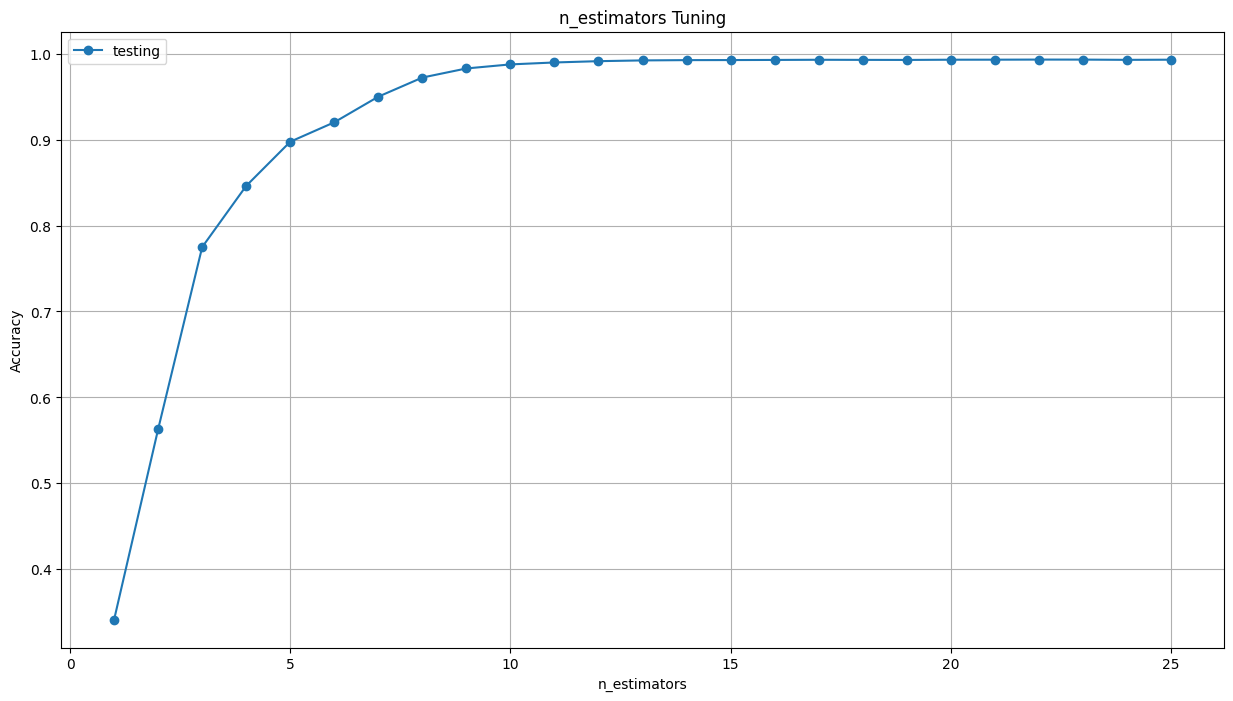

7.0


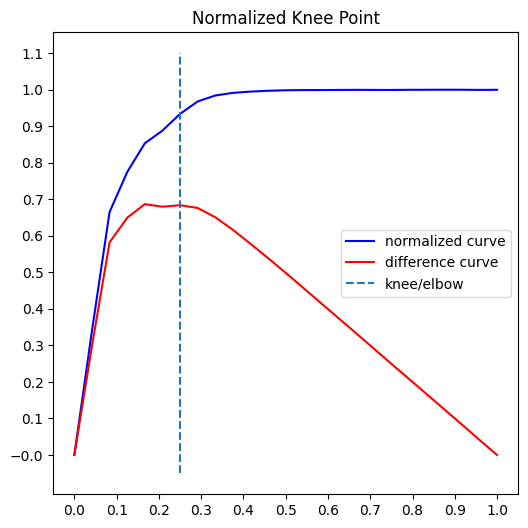

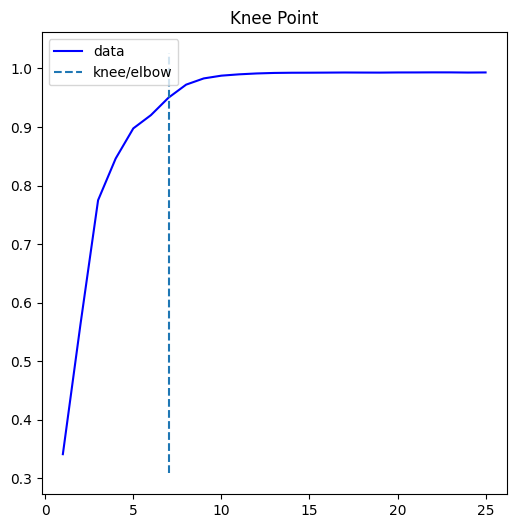

In [30]:
plt.figure(figsize=(15, 8))
plt.plot(rf, rf_acc_tChest, '-o', label="testing")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.grid()
plt.title("n_estimators Tuning")
plt.show()

kneedle = KneeLocator(rf, rf_acc_tChest.tolist(), S=1.0, curve="concave", direction="increasing")
print(round(kneedle.knee, 3))
kneedle.plot_knee_normalized()
kneedle.plot_knee()



In [31]:
model = RandomForestClassifier(n_estimators=15, max_depth=7)
model.fit(x_tChest, y_tChest)  

y_train_hat = model.predict(x_tChest)
y_test_hat = model.predict(X_test_tChest)

print(metrics.confusion_matrix(y_test_tChest, y_test_hat))
print(metrics.classification_report(y_test_tChest, y_test_hat))

[[105   2   0   0   0   0   1   0   0   0   0   0]
 [  5 112   0   0   0   0   1   0   0   0   0   0]
 [  0   0 128   0   0   0   0   0   0   0   0   0]
 [  0   0   0 112   5   0   0   0   0   0   0   0]
 [  0   0   0  13  87   0   0   0   0   0   0   0]
 [  0   0   0   0   0 111   0   2   0   0   0   0]
 [  1   0   0   0   0   0 123   0   0   0   0   0]
 [  0   0   0   0  10   0   0  81   0   0   0   0]
 [  0   0   0   0   0   0   0   0 113   0   0   0]
 [  0   0   0   0   0   0   0   0   0 117   2   0]
 [  0   0   0   0   0   0   0   0   0   6 109   2]
 [  0   0   0   0   0   0   0   0   0   3   4  32]]
              precision    recall  f1-score   support

    MHE_A_01       0.95      0.97      0.96       108
    MHE_A_02       0.98      0.95      0.97       118
    MHE_A_03       1.00      1.00      1.00       128
    MHE_A_04       0.90      0.96      0.93       117
    MHE_A_05       0.85      0.87      0.86       100
    MHE_A_06       1.00      0.98      0.99       113
    MHE_

In [32]:
feature_names = X_tChest.columns

feature_importances = model.feature_importances_

feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

feature_importances_df_sorted = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df_sorted)

feature_importances_df_sorted.to_csv("../Tesis/resultados/MHEALTH/150_75/tChest/ft_importance.csv", index=False)

                        Feature  Importance
15     std_Acctr_tChest_X(m/s2)    0.117420
8   median_Acctr_tChest_Z(m/s2)    0.092196
20     var_Acctr_tChest_Z(m/s2)    0.089181
9      min_Acctr_tChest_X(m/s2)    0.077238
17     std_Acctr_tChest_Z(m/s2)    0.071255
0      max_Acctr_tChest_X(m/s2)    0.069312
3     mean_Acctr_tChest_X(m/s2)    0.065152
12   rango_Acctr_tChest_X(m/s2)    0.049906
18     var_Acctr_tChest_X(m/s2)    0.049414
5     mean_Acctr_tChest_Z(m/s2)    0.048201
6   median_Acctr_tChest_X(m/s2)    0.044139
16     std_Acctr_tChest_Y(m/s2)    0.037395
19     var_Acctr_tChest_Y(m/s2)    0.032953
14   rango_Acctr_tChest_Z(m/s2)    0.026305
2      max_Acctr_tChest_Z(m/s2)    0.024198
13   rango_Acctr_tChest_Y(m/s2)    0.021062
7   median_Acctr_tChest_Y(m/s2)    0.020332
4     mean_Acctr_tChest_Y(m/s2)    0.018779
11     min_Acctr_tChest_Z(m/s2)    0.016626
10     min_Acctr_tChest_Y(m/s2)    0.014622
1      max_Acctr_tChest_Y(m/s2)    0.014312


In [33]:
acum_trans = collections.defaultdict(float)
acum_disp = collections.defaultdict(float)

for _, row in feature_importances_df.iterrows():
    feature = row["Feature"]
    importance = row["Importance"]
    trans, disp, pos = feature.split("_", 2)
    acum_trans[trans] += importance
    acum_disp[disp] += importance

lista_acum_trans = list(acum_trans.items())
lista_acum_disp = list(acum_disp.items())

df_acum_trans = pd.DataFrame(lista_acum_trans, columns=["Transformación", "Acumulado"])
df_acum_disp = pd.DataFrame(lista_acum_disp, columns=["Dispositivo", "Acumulado"])

df_acum_trans.to_csv("../Tesis/resultados/MHEALTH/150_75/tChest/acum_trans.csv", index=False)
df_acum_disp.to_csv("../Tesis/resultados/MHEALTH/150_75/tChest/acum_disp.csv", index=False)